# Gradient Boosting Regression on California Housing Dataset
This notebook demonstrates use of scikit-learn’s `GradientBoostingRegressor` for continuous prediction.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sns.set_theme()

## Data Loading & Exploration
Load the California Housing dataset and inspect its dimensions and summary statistics.

In [3]:
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='MedHouseValue')
print(f"Feature matrix: {X.shape}")

Feature matrix: (20640, 8)


In [4]:
display(X.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [5]:
print(y.describe())

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseValue, dtype: float64


## Exploratory Visualization
Plot **Median Income** vs **Median House Value** to inspect relationships.

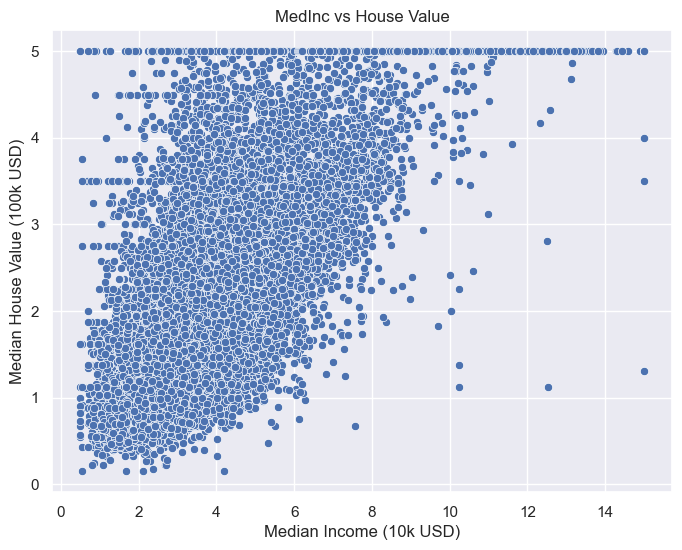

In [6]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X['MedInc'], y=y)
plt.xlabel('Median Income (10k USD)')
plt.ylabel('Median House Value (100k USD)')
plt.title('MedInc vs House Value')
plt.show()

## Train/Test Split
Split into 80% train and 20% test sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 16512, Test samples: 4128


Gradient boosting works by sequentially training new models on the old model's prediction errors. Iteratively, we get a better and better approximation of the true function.

Given features ```X``` and regression values ```y```, we train a regression tree ```tree_reg1``` on this data and then ```tree_reg1``` predicts a vector $\hat{y}_1$ of real values. Then,

$$
y - \hat{y}_1 = error_1
$$

Next fit another regression tree, say ```tree_reg2```, with features ```X``` and labels $y_2 = y - \hat{y}_1$. Then, ```tree_reg2``` predict a vector $\hat{y}_2$, with 

$$
error_1 = y_2 = \hat{y}_2 + error_2
$$

Thus, 

$$
y = \hat{y}_1 + error_1 = \hat{y}_1 + \hat{y}_2 + error_2, 
$$
where $error_1 > error_2$. 

As we continue iteratively, the error gets smaller and smaller.

## Training Default Gradient Boosting Regressor
Use default settings (`n_estimators=100`, `learning_rate=0.1`, `max_depth=3`).

In [8]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"R²:  {r2_score(y_test, y_pred):.3f}")

MSE: 0.294
MAE: 0.372
R²:  0.776


## Feature Importances
Plot the importance of each feature.

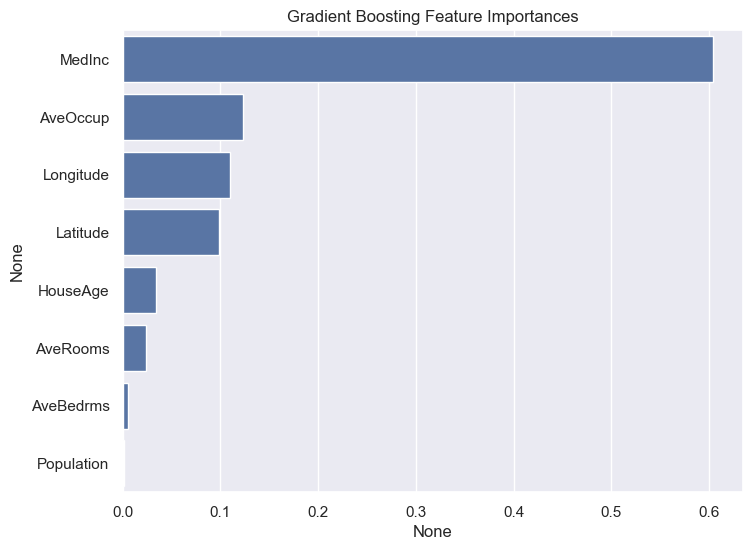

In [9]:
fi = pd.Series(gbr.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=fi, y=fi.index)
plt.title('Gradient Boosting Feature Importances')
plt.show()

## Predicted vs. Actual & Residual Distribution
Scatter plot and histogram of residuals.

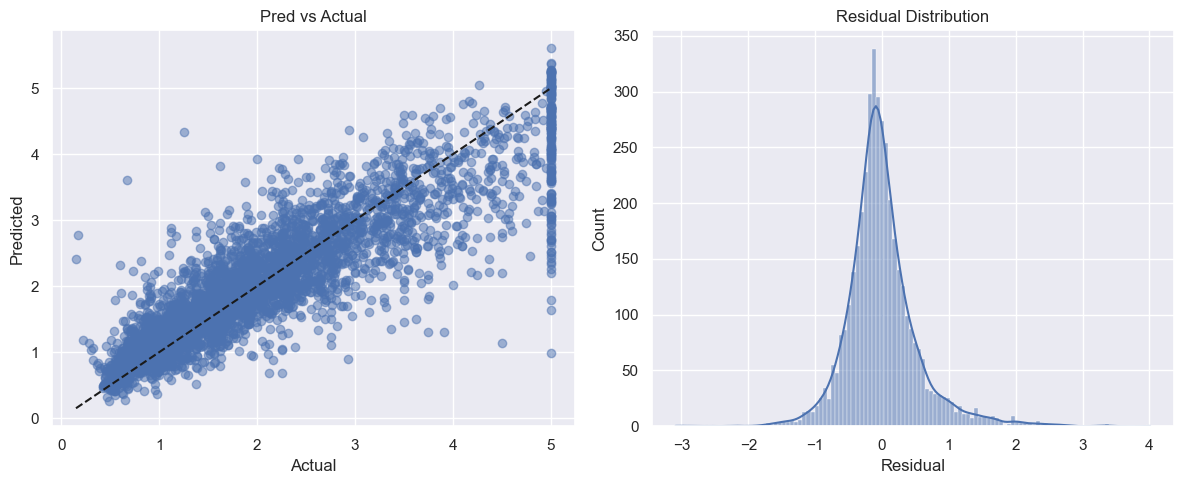

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()],'k--')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Pred vs Actual')
plt.subplot(1,2,2)
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel('Residual'); plt.title('Residual Distribution')
plt.tight_layout(); plt.show()

## Validation Curve: learning_rate
Plot training and CV MSE vs. learning rate.

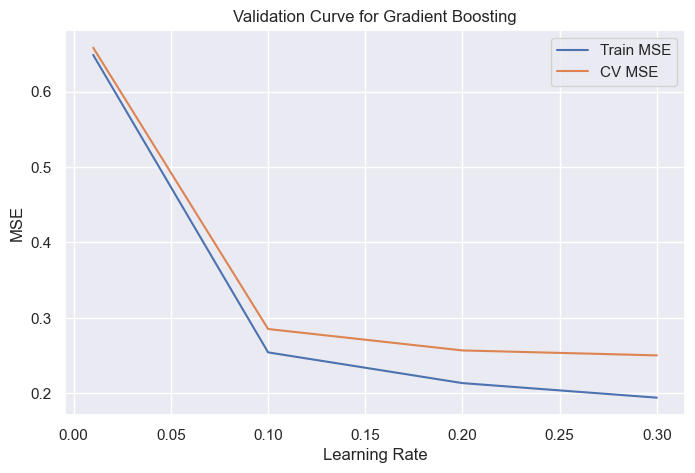

In [11]:
param_range = [0.01, 0.1, 0.2, 0.3]
train_scores, test_scores = validation_curve(
    GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    X_train, y_train, param_name='learning_rate', param_range=param_range,
    cv=5, scoring='neg_mean_squared_error'
)
train_mse = -train_scores.mean(axis=1)
test_mse = -test_scores.mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(param_range, train_mse, label='Train MSE')
plt.plot(param_range, test_mse, label='CV MSE')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.title('Validation Curve for Gradient Boosting')
plt.legend(); plt.grid(True); plt.show()

0.1 is about optimal for the learning rate.

## Effect of `n_estimators` & `max_depth` on Gradient Boosting Performance

We’ll use scikit-learn’s `validation_curve` to see how varying the number of trees (`n_estimators`) and the maximum depth of each tree (`max_depth`) affects our model’s test‐set MSE.  We keep the other hyperparameters at their cross-validated optimum (e.g.`learning_rate=0.1`).

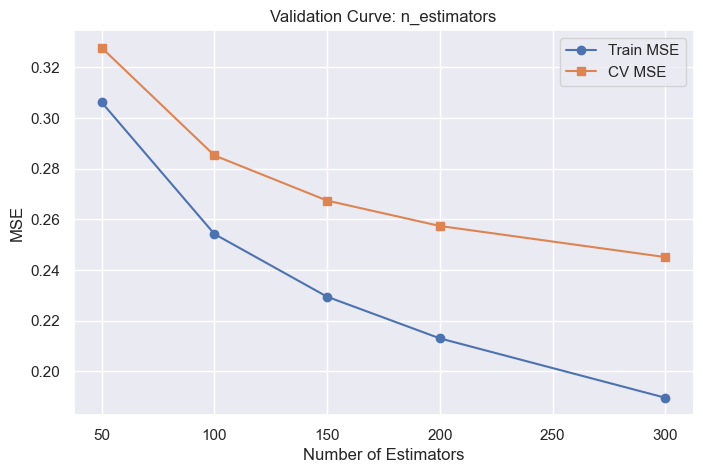

In [13]:
# 1) Validation curve for n_estimators
est_range = [50, 100, 150, 200, 300]
train_scores_e, test_scores_e = validation_curve(
    GradientBoostingRegressor(learning_rate=0.1, max_depth=3, random_state=42),
    X_train, y_train,
    param_name='n_estimators',
    param_range=est_range,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_mse_e = -train_scores_e.mean(axis=1)
test_mse_e  = -test_scores_e.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(est_range, train_mse_e, marker='o', label='Train MSE')
plt.plot(est_range, test_mse_e,  marker='s', label='CV MSE')
plt.xlabel('Number of Estimators')
plt.ylabel('MSE')
plt.title('Validation Curve: n_estimators')
plt.legend()
plt.grid(True)
plt.show()

300 is about the optimal number of estimators.

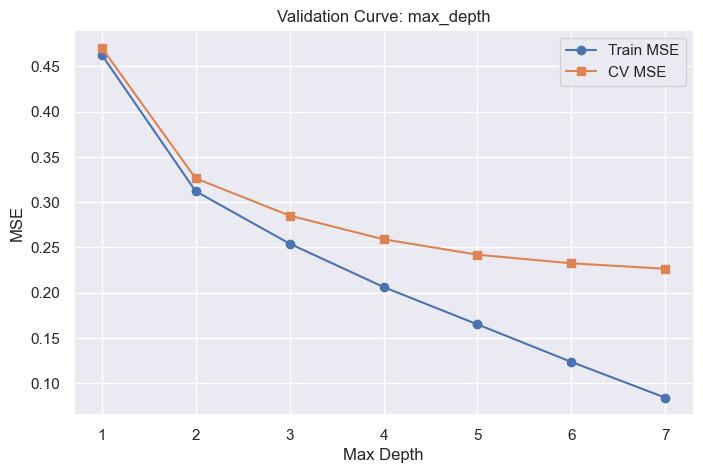

In [14]:
# 2) Validation curve for max_depth
depth_range = [1, 2, 3, 4, 5, 6, 7]
train_scores_d, test_scores_d = validation_curve(
    GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=42),
    X_train, y_train,
    param_name='max_depth',
    param_range=depth_range,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_mse_d = -train_scores_d.mean(axis=1)
test_mse_d  = -test_scores_d.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(depth_range, train_mse_d, marker='o', label='Train MSE')
plt.plot(depth_range, test_mse_d,  marker='s', label='CV MSE')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Validation Curve: max_depth')
plt.legend()
plt.grid(True)
plt.show()

Optimal max_depth is about 5.

## Comparison: Default vs. Optimized Gradient Boosting Regressor

We’ll train and evaluate two models on the same train/test split:

1. **Default** `GradientBoostingRegressor()`  
   (defaults: `n_estimators=100`, `learning_rate=0.1`, `max_depth=3`)  
2. **Optimized** `GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5)`

In [15]:
# --- Default model ---
gbr_def = GradientBoostingRegressor(random_state=42)
gbr_def.fit(X_train, y_train)
y_def = gbr_def.predict(X_test)
mse_def = mean_squared_error(y_test, y_def)
mae_def = mean_absolute_error(y_test, y_def)
r2_def  = r2_score(y_test, y_def)

# --- Optimized model ---
gbr_opt = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr_opt.fit(X_train, y_train)
y_opt = gbr_opt.predict(X_test)
mse_opt = mean_squared_error(y_test, y_opt)
mae_opt = mean_absolute_error(y_test, y_opt)
r2_opt  = r2_score(y_test, y_opt)

# --- Print results ---
print(f"Default GBR   → MSE: {mse_def:.3f}, MAE: {mae_def:.3f}, R²: {r2_def:.3f}")
print(f"Optimized GBR → MSE: {mse_opt:.3f}, MAE: {mae_opt:.3f}, R²: {r2_opt:.3f}")

Default GBR   → MSE: 0.294, MAE: 0.372, R²: 0.776
Optimized GBR → MSE: 0.217, MAE: 0.307, R²: 0.834


# Visualizations

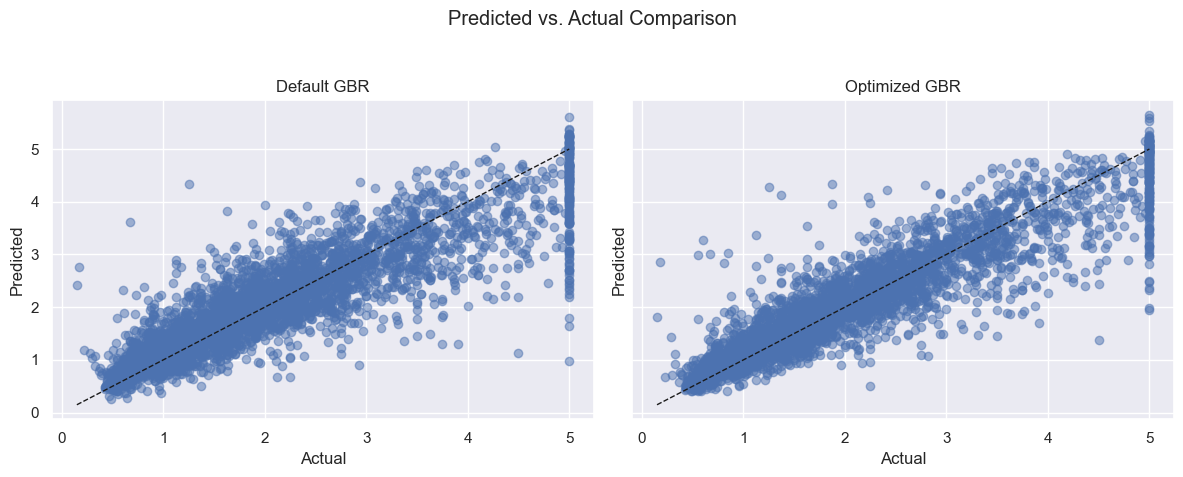

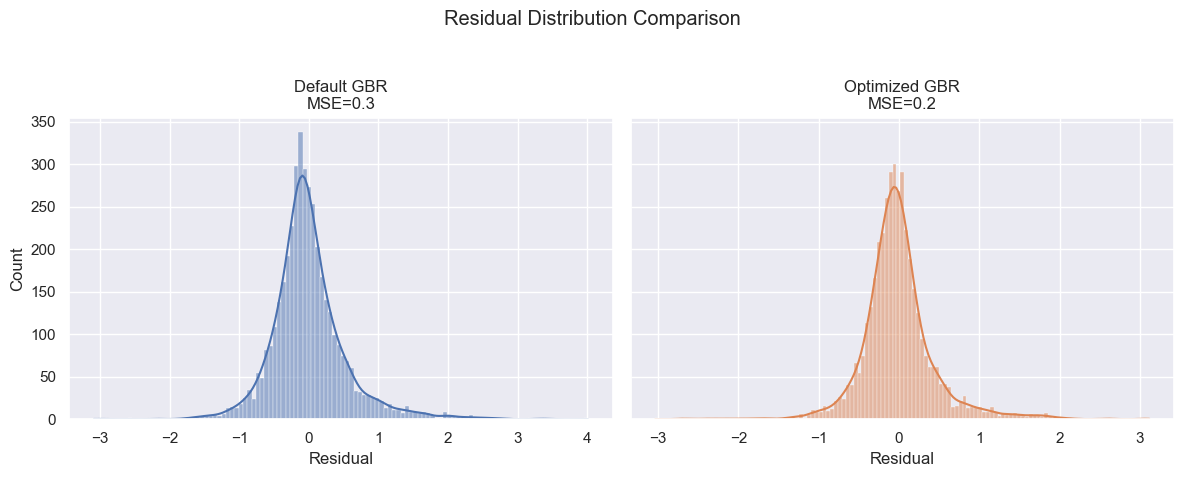

In [16]:
# 1) Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for ax, y_pred, title in zip(axes, [y_def, y_opt], ['Default GBR', 'Optimized GBR']):
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()], 'k--', linewidth=1)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(title)
plt.suptitle('Predicted vs. Actual Comparison')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2) Residual distributions
resid_def = y_test - y_def
resid_opt = y_test - y_opt

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.histplot(resid_def, kde=True, ax=axes[0], color='C0')
axes[0].set_title(f'Default GBR\nMSE={mean_squared_error(y_test, y_def):.1f}')
axes[0].set_xlabel('Residual')
sns.histplot(resid_opt, kde=True, ax=axes[1], color='C1')
axes[1].set_title(f'Optimized GBR\nMSE={mean_squared_error(y_test, y_opt):.1f}')
axes[1].set_xlabel('Residual')
plt.suptitle('Residual Distribution Comparison')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Discussion of Default vs. Optimized Gradient Boosting Results

- **Overall Error Reduction**  
  - **MSE** dropped from **0.294** to **0.217** (≈26% reduction), indicating that the optimized model’s squared deviations are substantially lower on average.  
  - **MAE** fell from **0.372** to **0.307**, so the typical absolute error decreased by roughly 17%.

- **Improved Variance Explanation**  
  - **R²** increased from **0.776** to **0.834**, showing that the optimized model now explains over 83% of the variance in the test set (up from 78%).  

- **Predicted vs. Actual Scatter**  
  - In the **Default GBR** plot, points are more widely dispersed around the diagonal, especially at the extremes (near the maximum house‐value on the right).  
  - The **Optimized GBR** scatter is visibly tighter around the 45° line, with fewer outliers and less vertical spread—signifying more accurate predictions across the full range of targets.

- **Residual Distributions**  
  - The **Default** residual histogram is wider and slightly skewed, with a longer tail of large positive errors (under-predictions).  
  - The **Optimized** residuals are more narrowly concentrated around zero and exhibit a more symmetric, peaked distribution. This reflects not only smaller average errors but also fewer extreme misses.

- **Bias–Variance Trade-Off**  
  - By increasing the number of trees (300), allowing deeper splits (max_depth=5), and retaining a moderate learning rate (0.1), we gave the model enough capacity to capture complex patterns—reducing bias—without over-fitting excessively—keeping variance in check.  
  - The net effect is both lower bias (better fit to the data) and controlled variance (no explosion of large errors), as reflected in the marked improvements in both MSE and R².

## Overall Discussion and Conclusions

- **Problem & Data**  
  We modeled median house values in California using the `GradientBoostingRegressor` on the California Housing dataset. This dataset features eight numeric predictors (e.g. median income, house age, rooms per household) and a continuous target, making it ideal for regression boosting.

- **Default Model Performance**  
  - **MSE:** 0.294  
  - **MAE:** 0.372  
  - **R²:** 0.776  
  The out-of-the-box model (100 trees, learning rate 0.1, max depth 3) captured much of the signal but still left substantial residual error and under-explained about 22% of the variance.

- **Diagnostic Visualizations**  
  - **Predicted vs. Actual** scatter: The default model’s points showed noticeable vertical spread around the 45° line—particularly for high-value homes—indicating systematic under/over-predictions.  
  - **Residual histogram**: A relatively wide, slightly skewed distribution with heavy tails pointed to both outliers and model bias in certain regions.

- **Hyperparameter Tuning Findings**  
  - **`n_estimators`**: Increasing from 100 to 300 improved bias without a huge variance penalty.  
  - **`max_depth`**: Allowing deeper trees (depth = 5) enabled the model to capture more complex nonlinearities.  
  - **`learning_rate`**: Retaining a moderate 0.1 balanced convergence speed against over-aggressive fitting of noise.

- **Optimized Model Performance**  
  - **MSE:** 0.217 (–26% relative)  
  - **MAE:** 0.307 (–17% relative)  
  - **R²:** 0.834 (+0.058 absolute)  
  The optimized ensemble explains over 83% of the variance, reduces large errors, and delivers tighter, more symmetric residuals, demonstrating both lower bias and well-controlled variance.

- **Bias–Variance Trade-Off**  
  - The default configuration leaned toward underfitting (higher bias).  
  - The optimized settings increased model capacity just enough to reduce bias while keeping overfitting in check, as evidenced by improved cross-validated MSE curves and stable test performance.

- **Key Takeaways**  
  1. **Boosting ensembles** can dramatically improve predictive accuracy by sequentially correcting residuals—especially on datasets with complex nonlinear structure.  
  2. **Hyperparameter tuning** (trees, depth, learning rate) is critical: small changes can yield substantial gains in MSE/MAE and R².  